In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [14]:
dataFrame = pd.read_csv('../files/card_transdata.csv')
dataFrame.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [15]:
count = dataFrame['fraud'].value_counts()

totalTransactions = count[1] + count[0]
noFrauds = count[1]
fraudRate = noFrauds/totalTransactions * 100

print("Number of frauds: " + str(noFrauds))
print("Number of transactions: " + str(totalTransactions))
print("Frauds Percentage: " + str(fraudRate))


Number of frauds: 87403
Number of transactions: 1000000
Frauds Percentage: 8.7403


In [16]:
#Dealing with missing data
dataFrame.isna().sum()
dataFrame.isnull().sum()
dataFrame = pd.read_csv('../files/card_transdata.csv', na_values=['NA'])
dataFrame.dropna()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


There aren't any missing values in this data set.

There aren't any null values in this data set.

In [17]:
#Dealing with duplicated data
length = len(dataFrame)
dataFrame.drop_duplicates(keep = False)
cleanedDups = len(dataFrame)

print("Before removing duplicated values: " + str(length))
print("After removing duplicated values: " + str(cleanedDups))

if length == cleanedDups:
    print("There aren't any duplicated objects")

Before removing duplicated values: 1000000
After removing duplicated values: 1000000
There aren't any duplicated objects


In [18]:
dataFrame.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
dataFrame = dataFrame.sample(100)

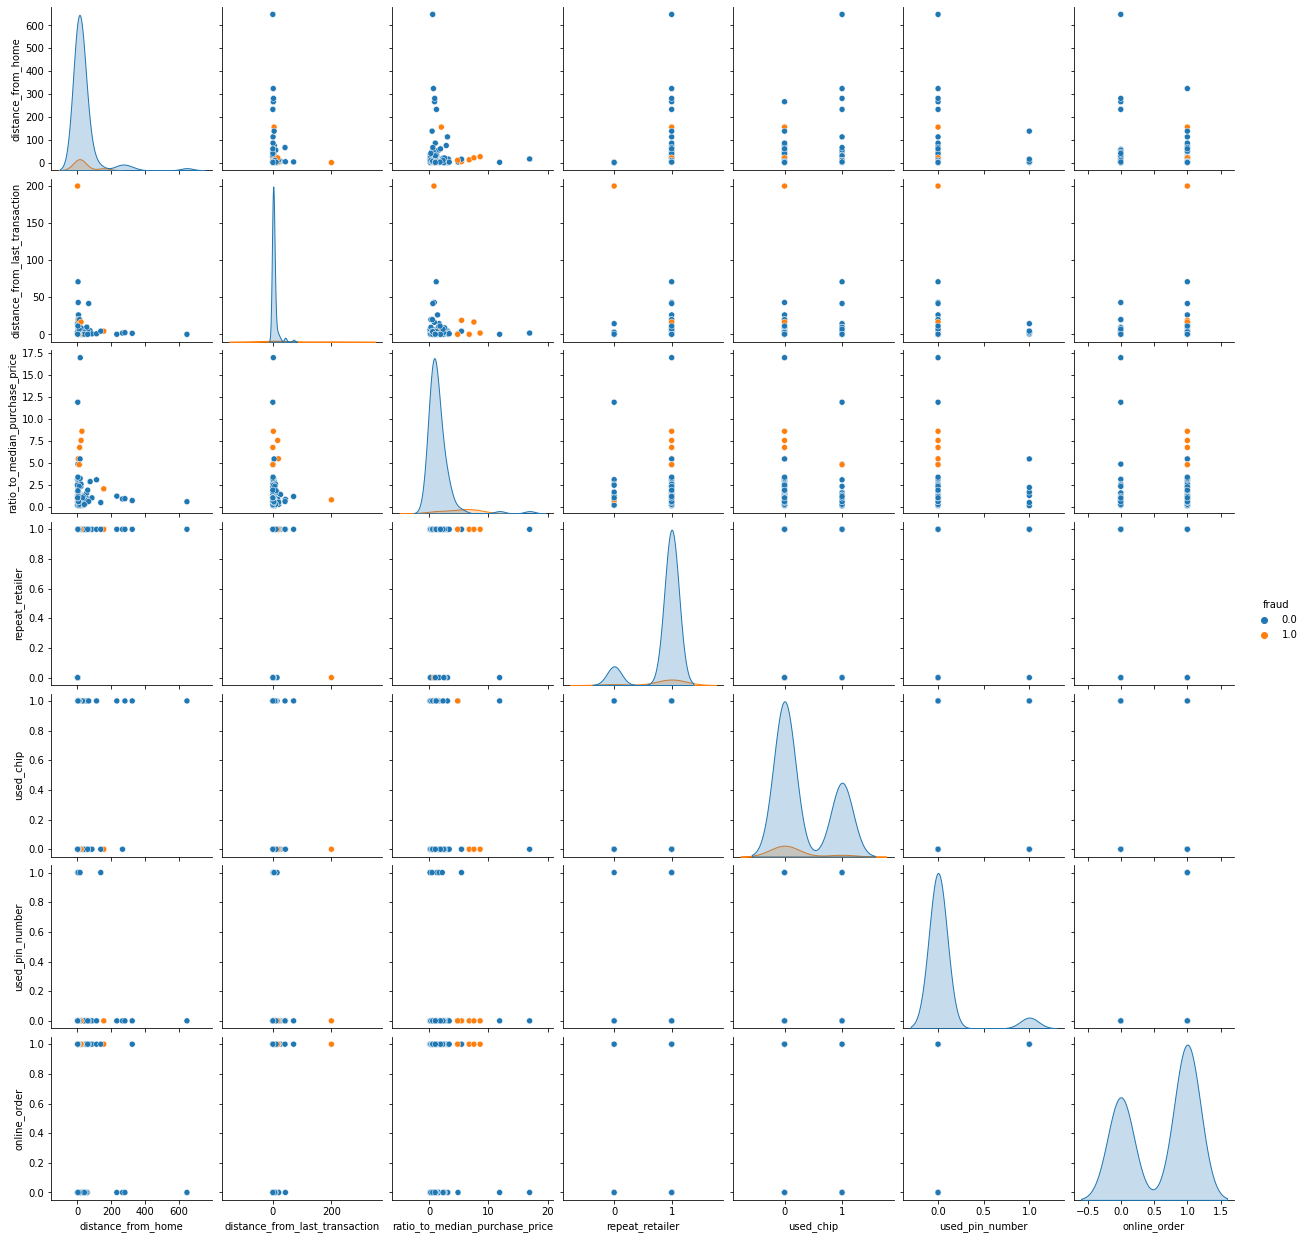

In [20]:
%matplotlib inline

sb.pairplot(dataFrame, hue='fraud')

In [21]:
dataFrame.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

In [22]:
feature = ['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order']

x = dataFrame[feature]
x

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
792452,8.953095,0.194003,1.280537,1.0,1.0,1.0,1.0
423863,26.517069,1.728137,8.588466,1.0,0.0,0.0,1.0
792537,10.565472,0.553595,0.536678,1.0,1.0,0.0,1.0
953826,0.898559,0.338783,1.263398,0.0,0.0,0.0,1.0
890050,266.498559,1.705166,0.884447,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
829490,3.096149,0.133755,0.985152,1.0,1.0,0.0,0.0
666107,3.500491,70.920210,1.162789,1.0,1.0,0.0,1.0
5838,2.731287,11.239677,1.813622,1.0,0.0,0.0,1.0
5521,60.673854,0.059067,1.887528,1.0,0.0,0.0,1.0


In [ ]:
correlation = dataFrame.corr()
correlation

In [ ]:
correlation.style.background_gradient(cmap='Greens')